In [1]:
import json
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit

<b>Читаем данные</b>

In [2]:
with open('data.json') as json_file:
    data = json.load(json_file)

In [3]:
points = list()
for key in data.keys():
    for formular in data[key]['formulars']:
        points.append((formular['cycle'], formular['distance']))

<b>Создадим класс для удобной работы с данными</b>

In [4]:
class NotDiscretisedError(RuntimeError):
    pass

class POI_Object:
    
    def __init__(self, data:list, og_idx = None):
        self.data = np.array(data)
        self.og_idx = og_idx
        self.discr = False
        self.eps = None
        self.div = None
        
    def f(self, x, a, b, c):
        return a * x**2 + b*x + c
    
    def crop(self, x1, x2, y1, y2):
        arr = self.data
        new = list()
        idx = list()
        for i in range(arr.shape[0]):
            if x1 <= arr[i,0] <= x2 and y1 <= arr[i,1] <= y2:
                idx.append(i)
                new.append((arr[i,0], arr[i,1]))
        return POI_Object(new, idx)

    def discretise(self, eps):
        self.eps = eps
        self.div = np.remainder(self.data[:,1], eps)
        self.discr = True
        self.data[:,1] = np.floor_divide(self.data[:,1], eps)
        self.data = np.array(self.data, dtype = int)
    
    def plot(self):
        plt.xlabel('cycle')
        plt.ylabel('distance')
        plt.scatter(self.data[:,0], self.data[:,1])
        
    def plot_track(self, a):
        plt.xlabel('cycle')
        plt.ylabel('distance')
        plt.scatter(self.data[:,0], self.data[:,1], color='green')
        plt.scatter(self.data[list(a),0], self.data[list(a),1], color='red')
        
    def plot_pred(self, a):
        x = np.arange(np.max(self.data[:,0]))
        plt.xlabel('cycle')
        plt.ylabel('distance')
        plt.scatter(self.data[:,0], self.data[:,1], color='green', label = 'noise')
        plt.scatter(x, self.f(x, *self.popt), color = 'blue', label = 'predicted')
        plt.scatter(self.data[list(a),0], self.data[list(a),1], color='red', label = 'detected')
        plt.legend()
        
    def undiscretise(self):
        if not self.discr:
            raise NotDiscretisedError()
        self.data = np.array(self.data, dtype = float)
        self.data[:,1] = self.data[:,1] * self.eps + self.div
        self.div = None
        self.discr = False
        self.eps = None
        
    def denoise(self, k = 3, thr = 5):
        """фильтрация по порогу на основе k-соседей"""
        new = list()
        idx = list()
        for i in range(self.data.shape[0]):
            dist = np.linalg.norm(self.data - self.data[i], axis = 1)
            dist = np.sort(dist)
            score = np.sum(dist[0:k+1])
            #print(score)
            if score < thr:
                new.append(self.data[i])
                idx.append(self.og_idx[i])
        return POI_Object(new,idx)
    
    def fit(self, a):
        train_x = points.data[list(a),0]
        train_y = points.data[list(a),1]
        self.popt, _ = curve_fit(self.f, train_x, train_y)
        
        
    def check(self):
        result = stats.linregress(self.data)
        return result.rvalue**2

In [5]:
points =  POI_Object(points)
points.data.shape

(548, 2)

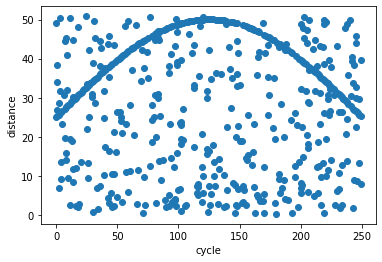

In [6]:
points.plot()

<b>Демонстрация функции выбора подмножества</b>

In [7]:
points1 = points.crop(0, 50, 20, 30)

In [8]:
points1.data.shape

(24, 2)

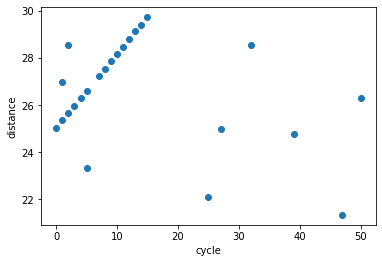

In [9]:
points1.plot()

<b>Демонстрация функции фильтрации</b>

In [10]:
points2 = points1.denoise()

In [11]:
#points1.discretise(0.2)

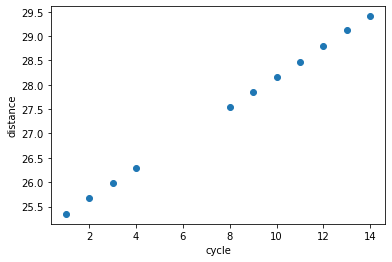

In [12]:
points2.plot()

<b>Демонстрация критерия принятия решения (на основе линейной регрессии, R-value)</b>

In [13]:
points2.check()

0.999977590816765

In [14]:
points1 = points.crop(100, 150, 0, 10)
points2 = points1.denoise()

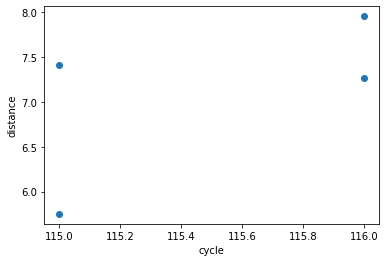

In [15]:
points2.plot()

In [16]:
points2.check()

0.3957705457846735

<b>Сам алгоритм</b>

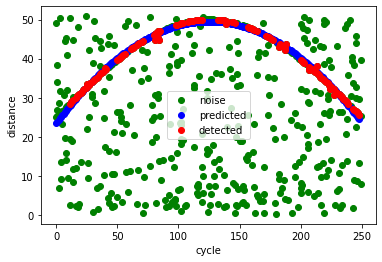

In [17]:
from collections import Counter
a = Counter()
for x in range(0,250,10):
    for y in range(0,60,5):
        #Выбираем подмножество
        points1 = points.crop(x, x+50, y, y+10)
        #Фильтруем
        points1 = points1.denoise(k = 4,thr = 9)
        #Смотрим, чтобы было достаточно точек
        if points1.data.shape[0] < 5:
            continue
        #Принимаем решение о принадлежности траектории
        if points1.check() > 0.7:
            a.update(points1.og_idx)
a = Counter(el for el in a.elements() if a[el] > 2)
#По полученным точкам строим модель и предсказываем для пропусков
points.fit(a)
points.plot_pred(a) 